
**INSTALLING LIBRARIES**



In [2]:
import numpy, sklearn, pandas
print("NumPy:", numpy.__version__, "| sklearn:", sklearn.__version__)


NumPy: 2.0.2 | sklearn: 1.5.1


**LOADING DATASETS**

In [3]:
import pandas as pd
from sqlalchemy import create_engine
MYSQL_USER = "root"
MYSQL_PASSWORD = "root"
MYSQL_HOST = "localhost"
MYSQL_PORT = 3306
MYSQL_DB = "food_recommneder_data"
TABLE_NAME = "recipes"
engine = create_engine(
    f"mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD}@{MYSQL_HOST}:{MYSQL_PORT}/{MYSQL_DB}"
)
recipes_df = pd.read_sql(f"SELECT * FROM recipes", con=engine)
reviews_df = pd.read_sql(f"SELECT * FROM reviews", con=engine)

In [4]:
import os, re, ast, csv
import numpy as np
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import gradio as gr

recipes_df = pd.read_sql(f"SELECT * FROM recipes", con=engine)
print("recipes table →", len(recipes_df.columns), "columns")
print("Column names:", recipes_df.columns.tolist())

# --- Check reviews.csv ---
# reviews_df = pd.read_csv(REVIEWS_CSV)  # read only first row
reviews_df = pd.read_sql(f"SELECT * FROM reviews", con=engine)

print("reviews table →", len(reviews_df.columns), "columns")
print("Column names:", reviews_df.columns.tolist())
# Hybrid weights & knobs
ALPHA_CF, BETA_CB, GAMMA_KB = 0.55, 0.35, 0.10
COLD_START_MIN = 5
TOPK_DEFAULT = 10
RANDOM_STATE = 42
# Scale controls (for Colab)
MIN_USER_RATINGS = 5
MIN_RATINGS_CF   = 5
MAX_RATINGS_TRAIN = 300_000   # set None to use all
# Assuming recipes_df and reviews_df are already loaded with data

print("--- recipes_df Dimensions ---")
print(f"Number of Rows (Recipes): {recipes_df.shape[0]}")
print(f"Number of Columns (Recipes): {recipes_df.shape[1]}")
print(f"Full Shape (Rows, Columns): {recipes_df.shape}")

print("\n--- reviews_df Dimensions ---")
print(f"Number of Rows (Reviews): {reviews_df.shape[0]}")
print(f"Number of Columns (Reviews): {reviews_df.shape[1]}")
print(f"Full Shape (Rows, Columns): {reviews_df.shape}")

c:\Users\aishw\Desktop\BDA_PROJECT\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


recipes table → 28 columns
Column names: ['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime', 'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions']
reviews table → 8 columns
Column names: ['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review', 'DateSubmitted', 'DateModified']
--- recipes_df Dimensions ---
Number of Rows (Recipes): 522569
Number of Columns (Recipes): 28
Full Shape (Rows, Columns): (522569, 28)

--- reviews_df Dimensions ---
Number of Rows (Reviews): 1401982
Number of Columns (Reviews): 8
Full Shape (Rows, Columns): (1401982, 8)


**DATA PREPROCESSING**

In [5]:
# ---- Drop-in robust parquet loader + path guard ----
import os, io, re, ast, csv, duckdb
import numpy as np
import pandas as pd



def _has_parquet_magic(path: str) -> bool:
    """True if file exists and starts/ends with 'PAR1'."""
    if not (path and os.path.exists(path) and os.path.isfile(path)):
        return False
    try:
        with open(path, "rb") as f:
            head = f.read(4)
            f.seek(-4, io.SEEK_END)
            tail = f.read(4)
        return head == b"PAR1" and tail == b"PAR1"
    except Exception:
        return False

def load_parquet_robust(path: str) -> pd.DataFrame:
    """Try pyarrow → fastparquet → DuckDB. If file isn't valid Parquet, raise."""
    # Quick sanity: reject if file clearly isn't Parquet
    if not _has_parquet_magic(path):
        raise ValueError(f"File is not valid Parquet (no magic bytes): {path}")

    # 1) pyarrow
    try:
        return pd.read_parquet(path, engine="pyarrow")
    except Exception as e1:
        # 2) fastparquet (optional)
        try:
            import fastparquet  # noqa: F401
            return pd.read_parquet(path, engine="fastparquet")
        except Exception as e2:
            # 3) DuckDB
            try:
                return duckdb.sql(f"SELECT * FROM read_parquet('{path}')").df()
            except Exception as e3:
                raise RuntimeError(
                    "All parquet readers failed.\n"
                    f"pyarrow: {type(e1).__name__}: {e1}\n"
                    f"fastparquet: {type(e2).__name__}: {e2}\n"
                    f"duckdb: {type(e3).__name__}: {e3}\n"
                    f"Path tried: {path}"
                )

def parse_listish(s):
    if isinstance(s, list): return [str(x).strip() for x in s]
    if isinstance(s, (int, float)) and pd.isna(s): return []
    if not isinstance(s, str): return []
    t = s.strip()
    if not t: return []
    t = re.sub(r'^\s*c\(', '[', t); t = re.sub(r'\)\s*$', ']', t)
    if (t.startswith('[') and t.endswith(']')) or (t.startswith('(') and t.endswith(')')):
        try:
            val = ast.literal_eval(t)
            if isinstance(val, (list, tuple)):
                return [str(x).strip() for x in val]
        except Exception:
            pass
    return [x.strip() for x in re.split(r"[,\s;|/]+", t) if x.strip()]

def iso8601_to_minutes(x):
    if not isinstance(x, str): return np.nan
    m = re.match(r'P?T?(?:(\d+)H)?(?:(\d+)M)?$', x.strip(), re.I)
    if not m: return np.nan
    h = int(m.group(1)) if m.group(1) else 0
    mm = int(m.group(2)) if m.group(2) else 0
    return h*60 + mm

def _normalize_recipes(df: pd.DataFrame) -> pd.DataFrame:
    if 'id' in df.columns and 'minutes' in df.columns:
        out = pd.DataFrame({
            'recipe_id': df['id'].astype(str),
            'name': df['name'].astype(str),
            'minutes': pd.to_numeric(df['minutes'], errors='coerce'),
            'tags': (df['tags'] if 'tags' in df.columns else pd.Series([""]*len(df))).apply(parse_listish),
            'ingredients': (df['ingredients'] if 'ingredients' in df.columns else pd.Series([""]*len(df))).apply(parse_listish),
            'description': (df['description'] if 'description' in df.columns else pd.Series([""]*len(df))).astype(str)
        })
        if 'nutrition' in df.columns:
            def _nut(v):
                try:
                    arr = list(ast.literal_eval(v)) if isinstance(v, str) else (v if isinstance(v, list) else [])
                except Exception:
                    arr = []
                arr = (arr + [np.nan]*7)[:7]
                return pd.Series(arr, index=['calories','fat','sugar','sodium','protein','sat_fat','carbs'])
            nut = df['nutrition'].apply(_nut)
            out = pd.concat([out, nut[['calories','fat','sat_fat','sodium','carbs','sugar','protein']]], axis=1)
        for c in ['calories','fat','sat_fat','cholesterol','sodium','carbs','fiber','sugar','protein']:
            if c not in out.columns: out[c] = np.nan
        return out

    rename = {
        'RecipeId':'recipe_id','Name':'name','Description':'description',
        'Keywords':'tags_raw','RecipeIngredientParts':'ingredients_raw',
        'TotalTime':'total_iso','CookTime':'cook_iso','PrepTime':'prep_iso',
        'Calories':'calories','FatContent':'fat','SaturatedFatContent':'sat_fat',
        'CholesterolContent':'cholesterol','SodiumContent':'sodium',
        'CarbohydrateContent':'carbs','FiberContent':'fiber',
        'SugarContent':'sugar','ProteinContent':'protein'
    }
    df = df.rename(columns={k:v for k,v in rename.items() if k in df.columns})
    assert {'recipe_id','name'}.issubset(df.columns), f"Missing recipe_id/name in recipes. Found: {df.columns.tolist()}"

    total_m = (df['total_iso'] if 'total_iso' in df.columns else pd.Series([np.nan]*len(df))).apply(iso8601_to_minutes)
    cook_m  = (df['cook_iso']  if 'cook_iso'  in df.columns else pd.Series([0]*len(df))).apply(iso8601_to_minutes)
    prep_m  = (df['prep_iso']  if 'prep_iso'  in df.columns else pd.Series([0]*len(df))).apply(iso8601_to_minutes)
    minutes = total_m.where(~total_m.isna(), cook_m.add(prep_m, fill_value=0))
    minutes = minutes.fillna(minutes.median() if minutes.notna().any() else 30)

    tags = (df['tags_raw'] if 'tags_raw' in df.columns else pd.Series([""]*len(df))).apply(parse_listish)
    ings = (df['ingredients_raw'] if 'ingredients_raw' in df.columns else pd.Series([""]*len(df))).apply(parse_listish)
    desc = (df['description'] if 'description' in df.columns else pd.Series([""]*len(df))).astype(str)

    out = pd.DataFrame({
        'recipe_id': df['recipe_id'].astype(str),
        'name': df['name'].astype(str),
        'minutes': minutes.astype(float),
        'tags': tags,
        'ingredients': ings,
        'description': desc,
        'calories': pd.to_numeric(df['calories'] if 'calories' in df.columns else pd.Series([np.nan]*len(df)), errors='coerce'),
        'fat': pd.to_numeric(df['fat'] if 'fat' in df.columns else pd.Series([np.nan]*len(df)), errors='coerce'),
        'sat_fat': pd.to_numeric(df['sat_fat'] if 'sat_fat' in df.columns else pd.Series([np.nan]*len(df)), errors='coerce'),
        'cholesterol': pd.to_numeric(df['cholesterol'] if 'cholesterol' in df.columns else pd.Series([np.nan]*len(df)), errors='coerce'),
        'sodium': pd.to_numeric(df['sodium'] if 'sodium' in df.columns else pd.Series([np.nan]*len(df)), errors='coerce'),
        'carbs': pd.to_numeric(df['carbs'] if 'carbs' in df.columns else pd.Series([np.nan]*len(df)), errors='coerce'),
        'fiber': pd.to_numeric(df['fiber'] if 'fiber' in df.columns else pd.Series([np.nan]*len(df)), errors='coerce'),
        'sugar': pd.to_numeric(df['sugar'] if 'sugar' in df.columns else pd.Series([np.nan]*len(df)), errors='coerce'),
        'protein': pd.to_numeric(df['protein'] if 'protein' in df.columns else pd.Series([np.nan]*len(df)), errors='coerce'),
    })
    return out

def _normalize_reviews(df: pd.DataFrame) -> pd.DataFrame:
    if {'user_id','recipe_id','rating'}.issubset(df.columns):
        out = df.copy()
    else:
        out = df.rename(columns={'AuthorId':'user_id','RecipeId':'recipe_id','Rating':'rating',
                                 'Review':'review_text','DateSubmitted':'date'})
        keep = [c for c in ['user_id','recipe_id','rating','review_text','date'] if c in out.columns]
        out = out[keep]
    out['user_id']   = out['user_id'].astype(str)
    out['recipe_id'] = out['recipe_id'].astype(str)
    out['rating']    = pd.to_numeric(out['rating'], errors='coerce')
    out = out[out['rating'].between(1,5)]
    return out

def load_recipes_any():
    return _normalize_recipes(recipes_df)

def load_reviews_any():
    return _normalize_reviews(reviews_df)

# ---- run loads ----
recipes = load_recipes_any()
reviews = load_reviews_any()
print(f"Recipes: {len(recipes):,} | Reviews: {len(reviews):,}")
display(recipes.head(3))
display(reviews.head(3))


Recipes: 522,569 | Reviews: 1,325,734


,recipe_id,name,minutes,tags,ingredients,description,calories,fat,sat_fat,cholesterol,sodium,carbs,fiber,sugar,protein
0,38,Low-Fat Berry Blue Frozen Dessert,1485.0,"[Dessert, Low Protein, Low Cholesterol, Health...","[blueberries, granulated sugar, vanilla yogurt...",Make and share this Low-Fat Berry Blue Frozen ...,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2
1,39,Biryani,265.0,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...","[saffron, milk, hot green chili peppers, onion...",Make and share this Biryani recipe from Food.com.,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4
2,40,Best Lemonade,35.0,"[Low Protein, Low Cholesterol, Healthy, Summer...","[sugar, lemons, rind of, lemon, zest of, fresh...",This is from one of my first Good House Keepi...,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3


,user_id,recipe_id,rating,review_text,date
0,2008,992,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z
1,1634,4384,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z
2,2046,4523,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z


**QUERY MODULE - DATA STORE**

**DATA ANALYTICS AND VISUALIZATION**

Intersecting recipe_ids: 265812 | merged rows: 1325778


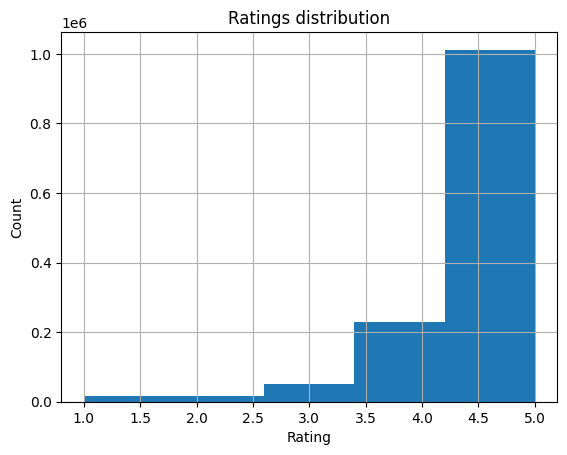

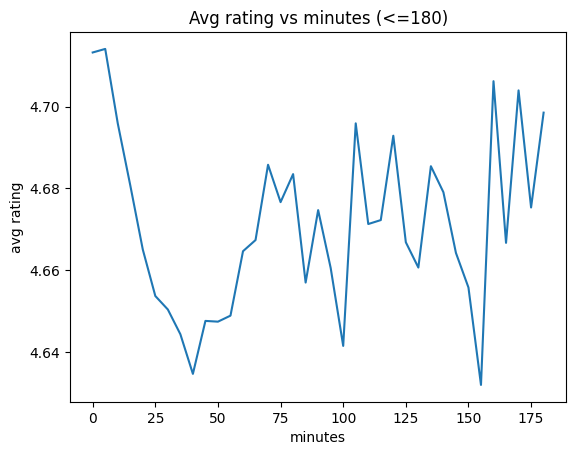

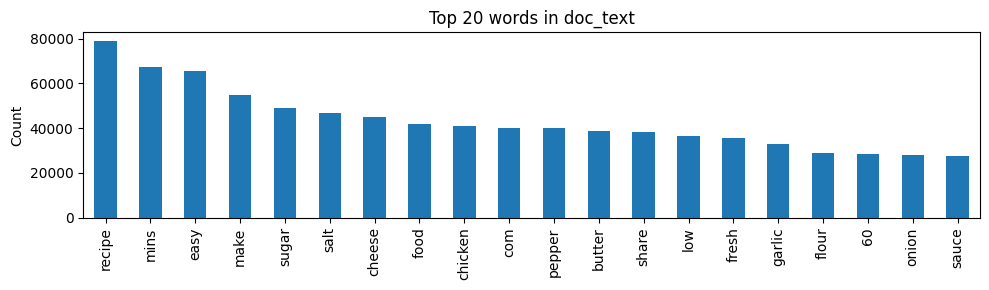

In [6]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
def canon_id(x):
    if pd.isna(x): return None
    if isinstance(x, (int, np.integer)): return str(int(x))
    if isinstance(x, (float, np.floating)):
        try:
            return str(int(x)) if float(x).is_integer() else str(int(round(float(x))))
        except Exception:
            return re.sub(r"\.0+$", "", str(x)).strip()
    s = str(x).strip()
    s = re.sub(r"\.0+$","", s)
    m = re.search(r"\d+", s)
    return m.group(0) if m else s

recipes['recipe_id'] = recipes['recipe_id'].apply(canon_id)
reviews['recipe_id'] = reviews['recipe_id'].apply(canon_id)

def parse_listish_strict(s):
    if isinstance(s, list): return [str(x).strip() for x in s if str(x).strip()]
    if not isinstance(s, str): return []
    t = s.strip()
    if not t or t.lower() in ("na", "none", "character(0)"): return []
    t = re.sub(r'^\s*c\(', '[', t); t = re.sub(r'\)\s*$', ']', t)
    if (t.startswith('[') and t.endswith(']')) or (t.startswith('(') and t.endswith(')')):
        try:
            val = eval(t, {"__builtins__":{}}, {})
            if isinstance(val, (list,tuple)):
                return [str(x).strip() for x in val if str(x).strip()]
        except Exception:
            pass
    return [x.strip() for x in re.split(r"[,\s;|/]+", t) if x.strip()]

def hydrate_tags_ingredients(rec):
    tag_candidates = ['Keywords','RecipeCategory','recipeCategory','Categories','tags']
    ing_candidates = ['RecipeIngredientParts','RecipeIngredients','Ingredients','ingredients','IngredientList']
    def pick(cols):
        for c in cols:
            if c in rec.columns: return rec[c]
        return pd.Series([""]*len(rec), index=rec.index)
    rec = rec.copy()
    rec['tags'] = pick(tag_candidates).apply(parse_listish_strict)
    rec['ingredients'] = pick(ing_candidates).apply(parse_listish_strict)
    return rec

recipes = hydrate_tags_ingredients(recipes)

def safe_col(col):
    return recipes[col].fillna("").astype(str) if col in recipes.columns else pd.Series([""]*len(recipes), index=recipes.index)

parts = [
    safe_col('name'),
    safe_col('description'),
    safe_col('RecipeInstructions') if 'RecipeInstructions' in recipes.columns else safe_col('Instructions'),
    safe_col('RecipeCategory') if 'RecipeCategory' in recipes.columns else safe_col('Categories'),
    recipes['tags'].apply(lambda xs: " ".join(xs) if isinstance(xs, list) else ""),
    recipes['ingredients'].apply(lambda xs: " ".join(xs) if isinstance(xs, list) else "")
]
recipes['doc_text'] = pd.concat(parts, axis=1).agg(" ".join, axis=1).str.replace(r"\s+"," ", regex=True).str.strip()

recipes['minutes'] = pd.to_numeric(recipes['minutes'], errors='coerce').clip(lower=0, upper=10000)

merged = reviews[['recipe_id','rating']].merge(recipes[['recipe_id','minutes']], on='recipe_id', how='inner')
print("Intersecting recipe_ids:", merged['recipe_id'].nunique(), "| merged rows:", len(merged))

reviews['rating'].hist(bins=5)
plt.title("Ratings distribution"); plt.xlabel("Rating"); plt.ylabel("Count")
plt.show()
mm = merged.dropna(subset=['minutes'])
mm = mm[mm['minutes'].between(0, 180)]
if mm.empty:
    print("No rows in [0,180] — check minutes values.")
else:
    mm['bucket'] = (mm['minutes'] // 5).astype(int) * 5
    g = mm.groupby('bucket')['rating'].mean().reset_index()
    plt.plot(g['bucket'], g['rating'])
    plt.title("Avg rating vs minutes (<=180)")
    plt.xlabel("minutes"); plt.ylabel("avg rating")
    plt.show()

sample_idx = np.random.RandomState(42).choice(len(recipes), size=min(100_000, len(recipes)), replace=False)
cv = CountVectorizer(stop_words='english', max_features=20000)
X = cv.fit_transform(recipes.loc[sample_idx, 'doc_text'])
sum_counts = np.asarray(X.sum(axis=0)).ravel()
vocab = np.array(sorted(cv.vocabulary_, key=cv.vocabulary_.get))
top_idx = sum_counts.argsort()[-20:][::-1]
top_words = pd.Series(sum_counts[top_idx], index=vocab[top_idx])
ax = top_words.plot(kind='bar', figsize=(10,3))
ax.set_title("Top 20 words in doc_text"); ax.set_ylabel("Count"); ax.set_xlabel("")
plt.tight_layout(); plt.show()

recipes_used = recipes[recipes['recipe_id'].isin(reviews['recipe_id'].unique())].copy()




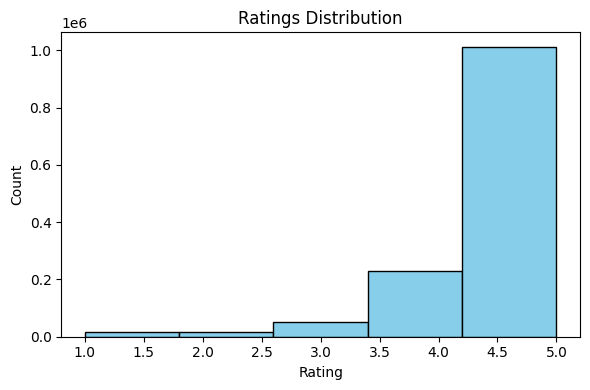


--------------------------------------------------------------------------------



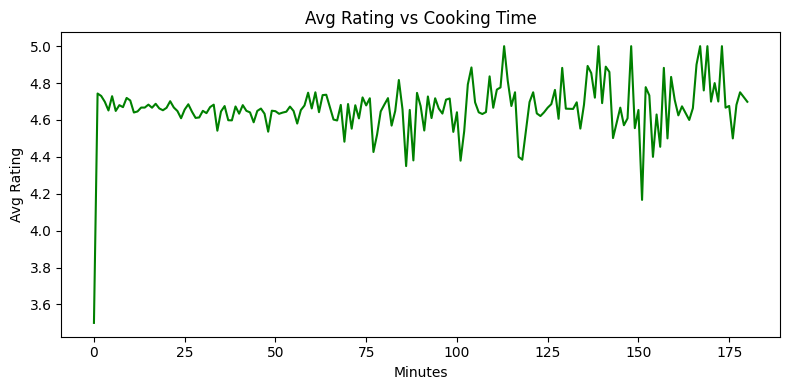


--------------------------------------------------------------------------------



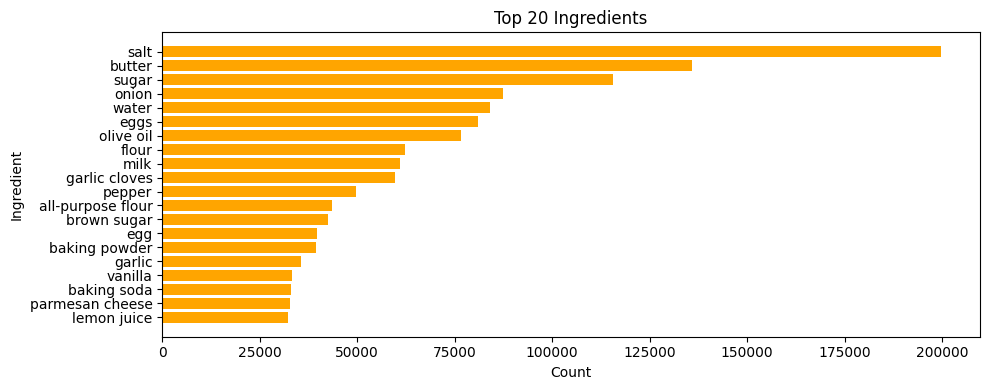


--------------------------------------------------------------------------------



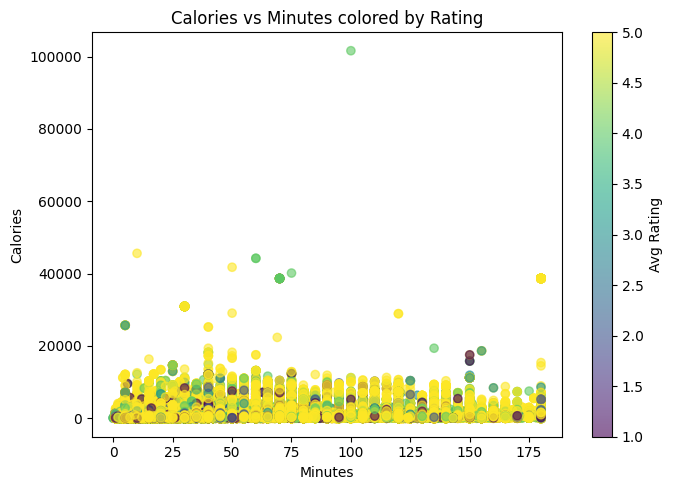


--------------------------------------------------------------------------------



C:\Users\aishw\AppData\Local\Temp\ipykernel_25476\41218577.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=buckets)


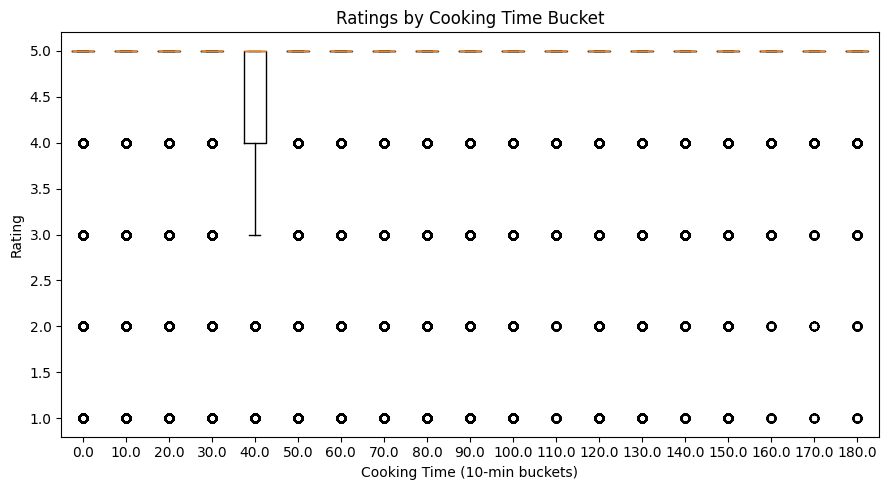


--------------------------------------------------------------------------------



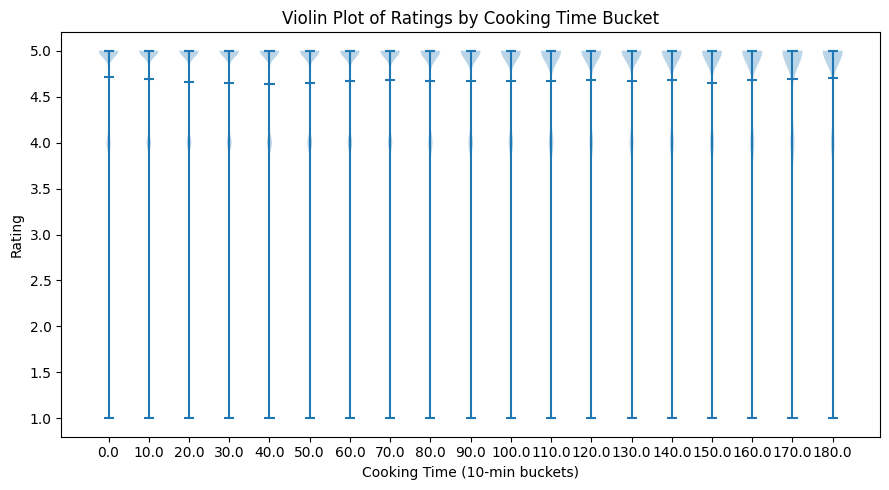


--------------------------------------------------------------------------------



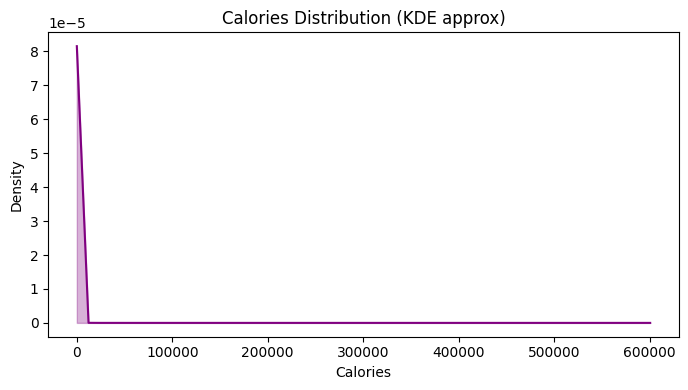


--------------------------------------------------------------------------------



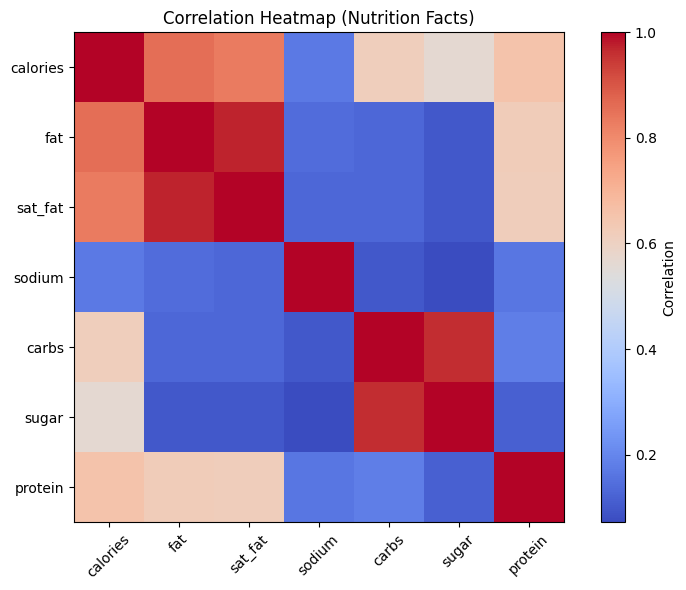


--------------------------------------------------------------------------------



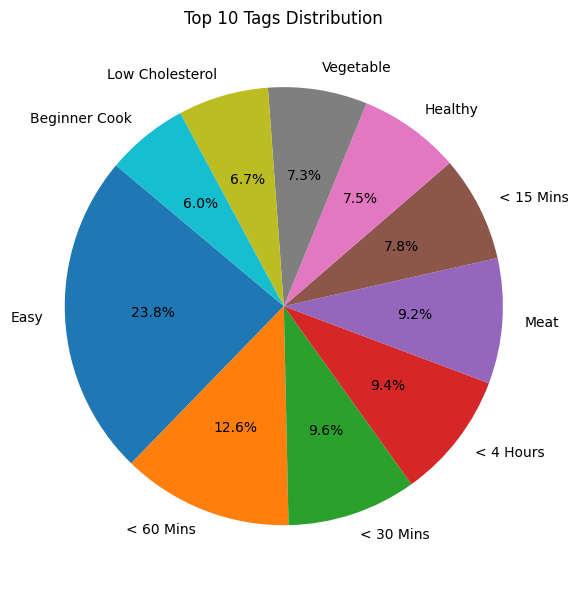


--------------------------------------------------------------------------------



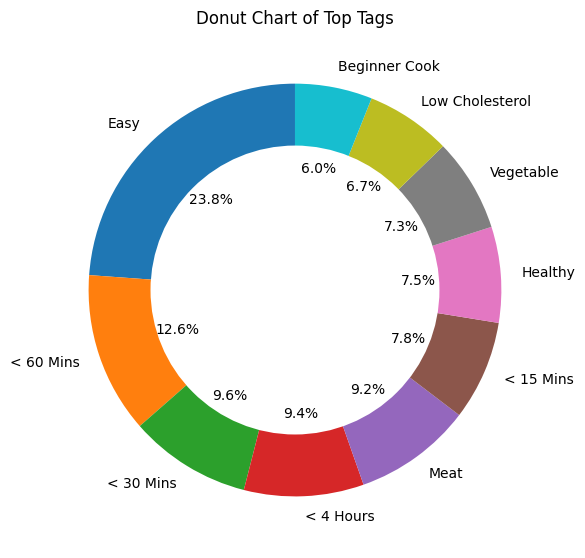


--------------------------------------------------------------------------------



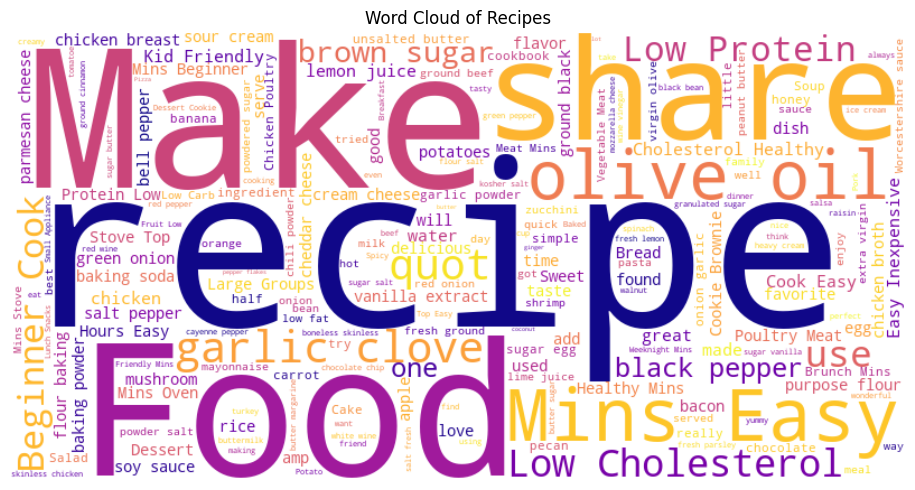


--------------------------------------------------------------------------------



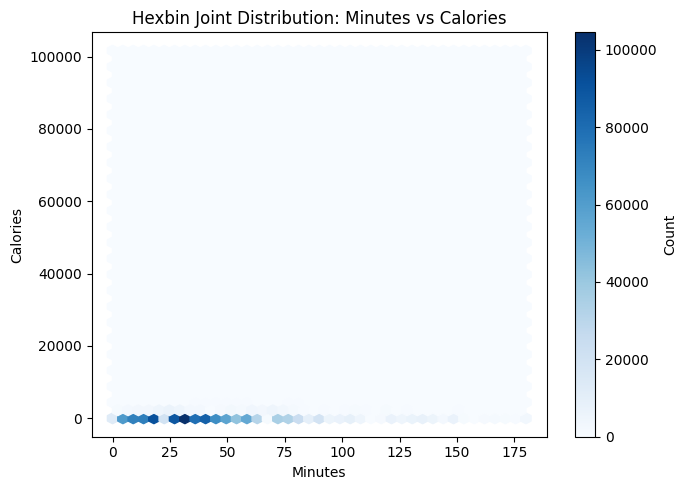


--------------------------------------------------------------------------------



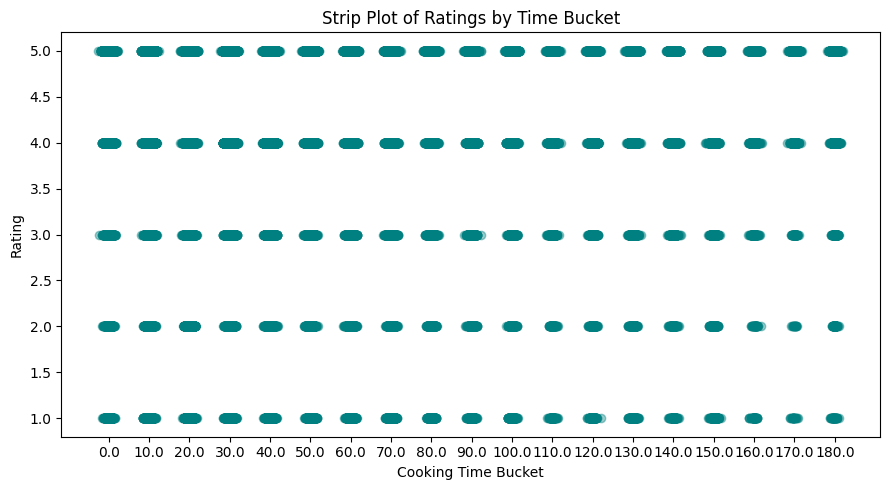


--------------------------------------------------------------------------------



In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud

def show_plot():
    plt.tight_layout()
    plt.show()
    print("\n" + "-"*80 + "\n")

plt.figure(figsize=(6,4))
plt.hist(reviews['rating'], bins=5, color="skyblue", edgecolor="black")
plt.title("Ratings Distribution")
plt.xlabel("Rating"); plt.ylabel("Count")
show_plot()

mm = reviews.merge(recipes[['recipe_id','minutes']], on='recipe_id', how='inner')
mm = mm[mm['minutes'].between(0,180)]
g = mm.groupby('minutes')['rating'].mean().reset_index()
plt.figure(figsize=(8,4))
plt.plot(g['minutes'], g['rating'], color="green")
plt.title("Avg Rating vs Cooking Time")
plt.xlabel("Minutes"); plt.ylabel("Avg Rating")
show_plot()

all_ings = [i for lst in recipes['ingredients'] if isinstance(lst,list) for i in lst]
top_ing = pd.Series(all_ings).value_counts().head(20)
plt.figure(figsize=(10,4))
plt.barh(top_ing.index[::-1], top_ing.values[::-1], color="orange")
plt.title("Top 20 Ingredients")
plt.xlabel("Count"); plt.ylabel("Ingredient")
show_plot()

m2 = mm.merge(recipes[['recipe_id','calories']], on="recipe_id", how="left")
plt.figure(figsize=(7,5))
sc = plt.scatter(m2['minutes'], m2['calories'], c=m2['rating'], cmap="viridis", alpha=0.6)
plt.colorbar(sc, label="Avg Rating")
plt.title("Calories vs Minutes colored by Rating")
plt.xlabel("Minutes"); plt.ylabel("Calories")
show_plot()

mm['bucket'] = (mm['minutes']//10)*10
buckets = sorted(mm['bucket'].unique())
data = [mm.loc[mm['bucket']==b, 'rating'] for b in buckets]
plt.figure(figsize=(9,5))
plt.boxplot(data, labels=buckets)
plt.title("Ratings by Cooking Time Bucket")
plt.xlabel("Cooking Time (10-min buckets)"); plt.ylabel("Rating")
show_plot()

plt.figure(figsize=(9,5))
plt.violinplot(data, showmeans=True, showmedians=True)
plt.xticks(np.arange(1,len(buckets)+1), buckets)
plt.title("Violin Plot of Ratings by Cooking Time Bucket")
plt.xlabel("Cooking Time (10-min buckets)"); plt.ylabel("Rating")
show_plot()

vals = recipes['calories'].dropna().values
plt.figure(figsize=(7,4))
counts, bins = np.histogram(vals, bins=50, density=True)
plt.plot(bins[:-1], counts, color="purple")
plt.fill_between(bins[:-1], counts, alpha=0.3, color="purple")
plt.title("Calories Distribution (KDE approx)")
plt.xlabel("Calories"); plt.ylabel("Density")
show_plot()

nut_cols = ['calories','fat','sat_fat','sodium','carbs','sugar','protein']
nutr = recipes[nut_cols].dropna()
corr = nutr.corr().values
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(nut_cols)), nut_cols, rotation=45)
plt.yticks(range(len(nut_cols)), nut_cols)
plt.title("Correlation Heatmap (Nutrition Facts)")
show_plot()

all_tags = [t for lst in recipes['tags'] if isinstance(lst,list) for t in lst]
tag_counts = pd.Series(all_tags).value_counts().head(10)
plt.figure(figsize=(6,6))
plt.pie(tag_counts.values, labels=tag_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Tags Distribution")
show_plot()

plt.figure(figsize=(6,6))
wedges, texts, autotexts = plt.pie(tag_counts.values, labels=tag_counts.index,
                                   autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Donut Chart of Top Tags")
show_plot()

text = " ".join(recipes['doc_text'].dropna().astype(str).sample(5000, random_state=42))
wc = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Recipes")
show_plot()

plt.figure(figsize=(7,5))
hb = plt.hexbin(m2['minutes'], m2['calories'], gridsize=40, cmap="Blues")
plt.colorbar(hb, label="Count")
plt.title("Hexbin Joint Distribution: Minutes vs Calories")
plt.xlabel("Minutes"); plt.ylabel("Calories")
show_plot()

plt.figure(figsize=(9,5))
for i, b in enumerate(buckets):
    y = mm.loc[mm['bucket']==b, 'rating']
    x = np.random.normal(i+1, 0.05, size=len(y)) 
    plt.plot(x, y, 'o', alpha=0.4, color="teal")
plt.xticks(range(1,len(buckets)+1), buckets)
plt.title("Strip Plot of Ratings by Time Bucket")
plt.xlabel("Cooking Time Bucket"); plt.ylabel("Rating")
show_plot()


**RECOMMENDATION MODEL CREATION**

**MODEL BASED - MATRIX FACTORIZATION**

In [8]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix



class CFModelNMF:
    def __init__(self, n_components=60, random_state=42, max_iter=500, init="nndsvd"):
        self.k=n_components; self.random_state=random_state; self.max_iter=max_iter; self.init=init
        self.user_index={}; self.item_index={}; self.U=None; self.V=None
    def fit(self, reviews_df):
        users = reviews_df['user_id'].astype(str).unique()
        items = reviews_df['recipe_id'].astype(str).unique()
        self.user_index = {u:i for i,u in enumerate(users)}
        self.item_index = {it:i for i,it in enumerate(items)}
        rows = reviews_df['user_id'].map(self.user_index).values
        cols = reviews_df['recipe_id'].map(self.item_index).values
        data = reviews_df['rating'].astype(float).values
        R = csr_matrix((data,(rows,cols)), shape=(len(users), len(items)))
        nmf = NMF(n_components=self.k, init=self.init, random_state=self.random_state, max_iter=self.max_iter)
        self.U = nmf.fit_transform(R); self.V = nmf.components_.T
        return self
    def predict_many(self, user_id, recipe_ids):
        if user_id not in self.user_index: return {rid:0.0 for rid in recipe_ids}
        u = self.U[self.user_index[user_id]]
        out={}
        for rid in recipe_ids:
            j=self.item_index.get(str(rid))
            out[rid]=float(np.dot(u,self.V[j])) if j is not None else 0.0
        return out

**USER BASED CF**

In [9]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import scipy.sparse as sps
class UserBasedCF:
    """
    Memory-based (neighborhood) collaborative filtering:
      - user-user cosine similarity on (optionally mean-centered) ratings
      - prediction: mu_u + sum_v sim(u,v) * (r_vi - mu_v) / sum |sim(u,v)|
      - shrinkage to temper small co-rating overlaps
    """
    def __init__(self, k_neighbors=50, center=True, shrinkage=10.0, min_common=1,
                 rating_min=1.0, rating_max=5.0, clip=True):
        self.k = k_neighbors
        self.center = center
        self.shrinkage = shrinkage
        self.min_common = min_common
        self.rating_min = rating_min
        self.rating_max = rating_max
        self.clip = clip
        self.user_index = {}
        self.index_user = []
        self.item_index = {}
        self.index_item = []
        self.R = None
        self.user_means = None
        self.user_item_sets = None
        self.item_user_lists = None
        self.Su = None

        self._co_counts = None  

    def fit(self, reviews_df: pd.DataFrame):
        users = reviews_df['user_id'].astype(str).unique()
        items = reviews_df['recipe_id'].astype(str).unique()
        self.user_index = {u: i for i, u in enumerate(users)}
        self.index_user = list(users)
        self.item_index = {it: j for j, it in enumerate(items)}
        self.index_item = list(items)

        rows = reviews_df['user_id'].map(self.user_index).to_numpy()
        cols = reviews_df['recipe_id'].map(self.item_index).to_numpy()
        data = reviews_df['rating'].astype(float).to_numpy()
        nU, nI = len(users), len(items)
        R = csr_matrix((data, (rows, cols)), shape=(nU, nI))

        if self.center:
            user_mean_map = reviews_df.groupby('user_id')['rating'].mean().astype(float)
            self.user_means = np.array([user_mean_map.get(u, np.nan) for u in self.index_user], dtype=float)
            R = R.tolil(copy=True)
            for i in range(nU):
                if R.rows[i]:
                    R.data[i] = [x - self.user_means[i] for x in R.data[i]]
            R = R.tocsr()
        else:
            self.user_means = np.zeros(nU, dtype=float)

        self.R = R

        self.user_item_sets = [set(R[i].indices.tolist()) for i in range(nU)]
        self.item_user_lists = [R[:, j].nonzero()[0].tolist() for j in range(nI)]

        self.Su = cosine_similarity(R)
        B = (R != 0).astype(np.int8)
        self._co_counts = (B @ B.T).tocsr()

        return self

    def _neighbors_for_item(self, u_idx, j_idx):
        """Return candidate neighbor user indices who rated item j."""
        cand = self.item_user_lists[j_idx]
        if not cand:
            return []

        sims = self.Su[u_idx, cand] if self.Su is not None else cosine_similarity(self.R[u_idx], self.R[cand]).ravel()
        sims = np.asarray(sims).ravel()

        if self._co_counts is not None:
            cc = self._co_counts[u_idx, cand] 
            commons = cc.toarray().ravel().astype(float) if sps.issparse(cc) else np.asarray(cc).ravel()
        else:
            commons = np.array([len(self.user_item_sets[u_idx].intersection(self.user_item_sets[v]))
                                for v in cand], dtype=float)

        mask = commons >= float(self.min_common)
        if not mask.any():
            return []

        cand = np.asarray(cand)[mask]
        sims = sims[mask]
        commons = commons[mask]

        if self.shrinkage > 0:
            sims = sims * (commons / (commons + float(self.shrinkage)))

        if sims.size > self.k:
            top_idx = np.argpartition(np.abs(sims), -self.k)[-self.k:]
            cand = cand[top_idx]
            sims = sims[top_idx]

        order = np.argsort(-np.abs(sims))
        return list(zip(cand[order], sims[order]))

    def _predict_one(self, u_idx, j_idx):
        """Predict rating for known user u on item j."""
        neigh = self._neighbors_for_item(u_idx, j_idx)
        if not neigh:
            base = self.user_means[u_idx] if not np.isnan(self.user_means[u_idx]) else 3.5
            return float(base)

        num = 0.0
        den = 0.0
        for v_idx, sim_uv in neigh:
            rvj = self.R[v_idx, j_idx]
            if sps.issparse(rvj):  
                rvj = rvj.toarray().item()
            if rvj == 0:
                continue
            num += sim_uv * rvj
            den += abs(sim_uv)

        base = self.user_means[u_idx] if self.center else 0.0
        pred = base if den == 0 else base + (num / den)
        return float(np.clip(pred, self.rating_min, self.rating_max) if self.clip else pred)

    def predict_many(self, user_id, recipe_ids):
        """Returns a dict {recipe_id: predicted_score}."""
        out = {}
        u_idx = self.user_index.get(str(user_id))
        if u_idx is None:
            prior = 3.5
            for rid in recipe_ids:
                out[rid] = float(prior)
            return out

        for rid in recipe_ids:
            j_idx = self.item_index.get(str(rid))
            if j_idx is None:
                base = self.user_means[u_idx] if not np.isnan(self.user_means[u_idx]) else 3.5
                out[rid] = float(base)
            else:
                out[rid] = self._predict_one(u_idx, j_idx)
        return out


**KB BASED - CONSTRAINT BASED**

In [10]:
def apply_kb(recipes_df, prefs):
    df = recipes_df.copy()
    if prefs.get("max_minutes"):  df=df[df['minutes']<=prefs['max_minutes']]
    if prefs.get("max_calories"): df=df[df['calories']<=prefs['max_calories']]
    bonus={}
    if prefs.get("cuisine"):
        mask = df.get('doc_text', "").astype(str).str.contains(prefs['cuisine'], case=False, na=False)
        bonus.update({rid:0.1 for rid in df.loc[mask,'recipe_id']})
    return df, bonus


In [14]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


class ContentBasedRecommender:
    def __init__(self, text_cols=None, max_features=10000):
        self.text_cols = text_cols or ["ingredients", "tags", "description"]
        self.max_features = max_features
        self.vectorizer = None
        self.tfidf_matrix = None
        self.recipe_ids = None
    def _safe_join(self, x):
        """Join safely whether x is list, numpy array, or string."""
        import ast, numbers
        if x is None:
            return ""
        if isinstance(x, numbers.Number):
            return str(x)
        if isinstance(x, (list, tuple, np.ndarray)):
            return " ".join(map(str, x))
        s = str(x).strip()
        if not s:
            return ""
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple)):
                    return " ".join(map(str, parsed))
            except Exception:
                pass
        return s
    def _combine_text(self, df):
        parts = []
        for col in self.text_cols:
            if col not in df.columns:
                continue
            col_text = df[col].apply(self._safe_join)
            parts.append(col_text)
        # join all text sources together
        return pd.Series([" ".join(x) for x in zip(*parts)], index=df.index)
    def fit(self, recipes_df):
        """Build TF-IDF embeddings for recipes."""
        print("Building TF-IDF embeddings for recipes...")
        self.recipe_ids = recipes_df["recipe_id"].astype(str).tolist()
        texts = self._combine_text(recipes_df)

        self.vectorizer = TfidfVectorizer(stop_words="english", max_features=self.max_features)
        self.tfidf_matrix = self.vectorizer.fit_transform(texts)

        print(f"TF-IDF built for {self.tfidf_matrix.shape[0]} recipes × {self.tfidf_matrix.shape[1]} features")
        return self
    def recommend_similar(self, recipe_id, topn=10):
        """Recommend similar recipes given a recipe_id."""
        if self.tfidf_matrix is None:
            raise RuntimeError("Model not fitted. Call fit() first.")
        if recipe_id not in self.recipe_ids:
            return pd.DataFrame(columns=["recipe_id", "similarity"])

        idx = self.recipe_ids.index(recipe_id)
        sims = cosine_similarity(self.tfidf_matrix[idx], self.tfidf_matrix).ravel()
        top_idx = np.argsort(-sims)[1: topn + 1]
        return pd.DataFrame({
            "recipe_id": [self.recipe_ids[i] for i in top_idx],
            "similarity": sims[top_idx]
        })
    def recommend_for_user(self, user_id, reviews_df, recipes_df, topn=10):
        """
        Recommend recipes for a user based on high-rated items (>=4).
        Combines the TF-IDF vectors of liked recipes to compute new recommendations.
        """
        liked = reviews_df[
            (reviews_df["user_id"].astype(str) == str(user_id)) &
            (reviews_df["rating"] >= 3)
        ]["recipe_id"].astype(str).tolist()

        if not liked:
            print(f"No liked recipes for user {user_id}")
            return pd.DataFrame(columns=["recipe_id", "score"])

        liked_idx = [self.recipe_ids.index(rid) for rid in liked if rid in self.recipe_ids]
        if not liked_idx:
            print(f"None of user {user_id}'s liked recipes found in TF-IDF index.")
            return pd.DataFrame(columns=["recipe_id", "score"])
        user_vec = np.mean(self.tfidf_matrix[liked_idx].toarray(), axis=0).reshape(1, -1)
        sims = cosine_similarity(user_vec, self.tfidf_matrix).ravel()

        recs = pd.DataFrame({"recipe_id": self.recipe_ids, "score": sims})
        recs = recs[~recs["recipe_id"].isin(liked)]  # exclude already liked
        top = recs.nlargest(topn, "score")

        top = top.merge(recipes_df[["recipe_id", "name", "minutes", "calories"]],
                        on="recipe_id", how="left")

        return top.reset_index(drop=True)



**Train/ Test Split for Collaborative Filtering**

In [12]:

from sklearn.model_selection import train_test_split
MIN_USER_RATINGS = 5; RANDOM_STATE = 42; MIN_RATINGS_CF = 5
def stratified_user_split(rev, test_size=0.2, min_ratings=MIN_USER_RATINGS):
    tr, te = [], []
    for uid, g in rev.groupby('user_id'):
        if len(g) < min_ratings: continue
        a,b = train_test_split(g, test_size=test_size, random_state=RANDOM_STATE)
        tr.append(a); te.append(b)
    return (pd.concat(tr).reset_index(drop=True), pd.concat(te).reset_index(drop=True)) if tr else (pd.DataFrame(),pd.DataFrame())

train, test = stratified_user_split(reviews)
u_ct = train['user_id'].value_counts(); i_ct = train['recipe_id'].value_counts()
active_users = u_ct[u_ct>=MIN_RATINGS_CF].index; active_items = i_ct[i_ct>=MIN_RATINGS_CF].index
train_cf = train[train['user_id'].isin(active_users) & train['recipe_id'].isin(active_items)].reset_index(drop=True)



**TRAINING USER BASED CF MODEL**

In [15]:

cf1 = UserBasedCF(
    k_neighbors=50,  
    center=True,      
    shrinkage=20.0,  
    min_common=2,     
    clip=True 
).fit(train_cf)

import numpy as np
import pandas as pd

cf_model = UserBasedCF(
    k_neighbors=50,
    center=True,
    shrinkage=20.0,
    min_common=2,
    clip=True
).fit(train_cf)

recipes_lookup = (recipes_used
                  .copy()
                  .assign(recipe_id=lambda d: d["recipe_id"].astype(str))
                  .set_index("recipe_id"))[["name","minutes","calories"]]

pop = (reviews.copy()
       .assign(recipe_id=lambda d: d["recipe_id"].astype(str))
       .groupby("recipe_id")["rating"]
       .agg(["mean","count"])
       .rename(columns={"mean":"pop_mean","count":"pop_cnt"}))
pop["pop_score"] = pop["pop_mean"].fillna(0.0) * np.log1p(pop["pop_cnt"].fillna(0.0))


In [16]:

cb_model = ContentBasedRecommender(
    text_cols=["ingredients", "tags", "description", "doc_text"],  # choose text columns
    max_features=10000
)

cb_model.fit(recipes)
similar = cb_model.recommend_similar("12345", topn=5)
print(similar)




Building TF-IDF embeddings for recipes...
TF-IDF built for 522569 recipes × 10000 features
  recipe_id  similarity
0    407652    0.537911
1    478434    0.529639
2    431171    0.525893
3     42711    0.517477
4    415037    0.509469


In [17]:

active_users = (
    train.groupby("user_id")["rating"]
    .apply(lambda x: (x >= 4).sum())
    .loc[lambda s: s > 0]
    .index
    .tolist()
)
print(f"{len(active_users)} users with ≥4 ratings")
user_id = np.random.choice(active_users)
print("Testing user:", user_id)
cb_user_recs = cb_model.recommend_for_user(
    user_id=user_id,
    reviews_df=train,
    recipes_df=recipes,
    topn=10
)
print(cb_user_recs[["recipe_id", "score", "name"]])


26387 users with ≥4 ratings
Testing user: 866729
  recipe_id     score                                    name
0     53833  0.441943                Zesty Tomato-Garlic Fish
1     19456  0.437823                 Green Bean Tomato Salad
2     58732  0.404650          Green Beans With Lemon and Oil
3    293923  0.403148                  Fresh Green Bean Salad
4    399549  0.400199        Warm Green Bean and Potato Salad
5    316732  0.390887     Broccoli, Corn and Black Bean Salad
6    539980  0.390376  Cod Fish Fillets in a White Wine Sauce
7    539986  0.389974                  Cod Fish in Wine Sauce
8    343390  0.388966                          Lemon Broccoli
9     55339  0.386192         So Good Beef and Broccoli Salad


**Defining User Likes and Candidate Set for Evaluation**

In [18]:
train_likes = train.loc[train['rating']>=4].groupby('user_id')['recipe_id'].agg(list).to_dict()
test_likes  = test.loc[test['rating']>=4].groupby('user_id')['recipe_id'].agg(list).to_dict()
prefs = {
    "max_minutes": 60,
    "max_calories": 900,
    "min_protein": 10, 
    "max_fat": 20,       
    "cuisine": None
}
filtered, kb_bonus = apply_kb(recipes_used, prefs)
candidates = filtered['recipe_id'].tolist()

**RELEVANCE / RANKING MODULE**

**Hybrid Fusion of User-Based CF and Knowledge-Based Scores**

In [20]:
def fuse_scores_cf_cb_kb(
    user_id,
    candidate_ids,
    cf,
    cb_model,
    kb_bonus,
    reviews_df,
    recipes_df,
    alpha=0.6,  # CF weight
    beta=0.3,   # CB weight
    gamma=0.1,  # KB weight
    cold_min=5,
    user_hist_len=0
):
    """
    Hybrid fusion of User-Based CF + Content-Based + KB filtering.

    Parameters:
    ----------
    user_id : str
        Current user ID.
    candidate_ids : list[str]
        Recipe IDs to score.
    cf : UserBasedCF
        Trained collaborative filtering model.
    cb_model : ContentBasedRecommender
        Trained content-based recommender.
    kb_bonus : dict
        Knowledge-based score boosts {recipe_id: bonus}.
    reviews_df : pd.DataFrame
        User–recipe ratings dataframe (for user profile in CB).
    recipes_df : pd.DataFrame
        Recipes dataframe (for CB text lookup).
    alpha, beta, gamma : float
        Weights for CF, CB, and KB components respectively.
    cold_min : int
        If user has < cold_min ratings, reduce CF weight.
    user_hist_len : int
        Number of ratings user has in training data.
    """

    # 🧊 Cold-start handling
    if user_hist_len < cold_min:
        alpha, beta, gamma = 0.3, 0.5, 0.2

    # ---------------- CF PREDICTIONS ----------------
    cf_scores = cf.predict_many(user_id, candidate_ids)

    # ---------------- CB PREDICTIONS ----------------
    cb_scores_df = cb_model.recommend_for_user(
        user_id=user_id,
        reviews_df=reviews_df,
        recipes_df=recipes_df,
        topn=len(candidate_ids)
    )
    cb_scores = dict(zip(cb_scores_df["recipe_id"].astype(str), cb_scores_df["score"]))

    # ---------------- FUSION ----------------
    fused = {}
    for rid in candidate_ids:
        cf_score = cf_scores.get(rid, 0.0)
        cb_score = cb_scores.get(rid, 0.0)
        kb_score = kb_bonus.get(rid, 0.0)
        fused[rid] = alpha * cf_score + beta * cb_score + gamma * kb_score
    if fused:
        vals = np.array(list(fused.values()), dtype=float)
        min_s, max_s = vals.min(), vals.max()

        if max_s > min_s:
            fused = {k: (v - min_s) / (max_s - min_s + 1e-8) for k, v in fused.items()}
        else:
            fused = {k: 0.0 for k in fused}

        # ✅ Debug info (optional)
        print(f"[DEBUG] Normalization range: {min_s:.4f} → {max_s:.4f}")
        print(f"[DEBUG] Sample normalized scores: {list(fused.items())[:5]}")


    # Return as sorted dict by score
    return dict(sorted(fused.items(), key=lambda kv: kv[1], reverse=True))


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def recommend_cf_cb_kb(
    cf_model,
    cb_model,
    recipes_df,
    reviews_df,
    user_id: str | None = None,
    seed_recipe_ids: list[str] | None = None,
    prefs: dict | None = None,
    topn: int = 10,
    alpha_cf: float = 0.6,   # CF weight
    beta_cb: float = 0.3,    # CB weight
    gamma_kb: float = 0.1,   # KB weight
):
    """
    Unified hybrid recommender:
      - User-Based CF (neighborhood model)
      - Content-Based TF-IDF (CB)
      - Knowledge-Based filter/bonus (KB)
    """
    prefs = prefs or {}
    filtered, kb_bonus = apply_kb(recipes_df, prefs)
    candidates = [str(r) for r in filtered["recipe_id"].astype(str).tolist()]
    if not candidates:
        return pd.DataFrame(columns=["recipe_id", "name", "minutes", "calories", "score"])

    seen = set()
    if user_id is not None:
        u = str(user_id)
        seen |= set(reviews_df.loc[reviews_df["user_id"].astype(str) == u, "recipe_id"].astype(str))
    if seed_recipe_ids:
        seen |= set(map(str, seed_recipe_ids))
    if seen:
        candidates = [c for c in candidates if c not in seen]
    if not candidates:
        return pd.DataFrame(columns=["recipe_id", "name", "minutes", "calories", "score"])
    hist_len = 0
    if user_id is not None:
        hist_len = int((reviews_df["user_id"].astype(str) == str(user_id)).sum())

    if hist_len == 0:
        tmp = pd.DataFrame({"recipe_id": candidates})
        tmp = tmp.join(pop[["pop_score"]], on="recipe_id")
        tmp["pop_score"] = tmp["pop_score"].fillna(0.0)
        tmp["kb_bonus"] = tmp["recipe_id"].map(lambda x: kb_bonus.get(str(x), 0.0))
        tmp["score"] = 0.9 * tmp["pop_score"] + 0.1 * tmp["kb_bonus"]
        top = tmp.nlargest(topn, "score")
        return top.merge(
            recipes_lookup, left_on="recipe_id", right_index=True, how="left"
        )[["recipe_id", "name", "minutes", "calories", "score"]]

    if hist_len < 5:
        alpha_cf, beta_cb, gamma_kb = 0.3, 0.6, 0.1

    cf_raw = cf_model.predict_many(str(user_id), candidates)
    cf_norm = {rid: float(np.clip((float(s) - 1.0) / 4.0, 0.0, 1.0)) for rid, s in cf_raw.items()}
    liked = reviews_df[
        (reviews_df["user_id"].astype(str) == str(user_id)) &
        (reviews_df["rating"] >= 4)
    ]["recipe_id"].astype(str).tolist()
    cb_scores = {}
    if liked:
        liked_idx = [cb_model.recipe_ids.index(r) for r in liked if r in cb_model.recipe_ids]
        if liked_idx:
            user_vec = np.mean(cb_model.tfidf_matrix[liked_idx].toarray(), axis=0).reshape(1, -1)
            sims = cosine_similarity(user_vec, cb_model.tfidf_matrix).ravel()
            for rid, s in zip(cb_model.recipe_ids, sims):
                cb_scores[rid] = s
    fused = {}
    for rid in candidates:
        scf = cf_norm.get(rid, 0.0)
        scb = cb_scores.get(rid, 0.0)
        skb = kb_bonus.get(rid, 0.0)
        fused[rid] = alpha_cf * scf + beta_cb * scb + gamma_kb * skb

    top_pairs = sorted(fused.items(), key=lambda kv: kv[1], reverse=True)[:topn]
    top_df = pd.DataFrame(top_pairs, columns=["recipe_id", "score"])
    top_df = top_df.merge(recipes_lookup, left_on="recipe_id", right_index=True, how="left")

    return top_df[["recipe_id", "name", "minutes", "calories", "score"]]


**CF-KB Hybrid Recommendation Engine**

In [22]:
user_id = "1328191"
prefs = {
    "max_minutes": 60,         
    "max_calories": 900,       
    "cuisine": None,           
    "diet_type": "Any",         
    "protein_pref": None,       
    "spice_level": "Medium",  
    "health_weight": 0.3,     
    "time_weight": 0.3      
}
hybrid_recs = recommend_cf_cb_kb(
    cf_model=cf_model,
    cb_model=cb_model,
    recipes_df=recipes_used,
    reviews_df=train,
    user_id=user_id,
    prefs=prefs,
    topn=10
)

print(hybrid_recs)


  recipe_id                                     name  minutes  calories  \
0    509006               Ravioli and Vegetable Soup     30.0     112.8   
1    352832              Cornmeal Oven-Fried Chicken     60.0     676.1   
2    106342                     Onion Zucchini Bread     55.0     264.1   
3    254739                            Easy Marinara     40.0     233.8   
4     50071              Zesty Zucchini Saut&eacute;     25.0     153.4   
5    286853                           Zucchini Bites     42.0     198.0   
6    432109                           Marinara Sauce     30.0     582.6   
7    193389  Chicken With Fresh Herbs and Vegetables     30.0     300.5   
8    331997                            Zucchini Bars     45.0      79.3   
9    289132                             Zucchini Pie     50.0     417.8   

      score  
0  0.400408  
1  0.399676  
2  0.393401  
3  0.385186  
4  0.384351  
5  0.383820  
6  0.383198  
7  0.383005  
8  0.382077  
9  0.381952  


In [23]:
print(recipes_used.columns)


Index(['recipe_id', 'name', 'minutes', 'tags', 'ingredients', 'description',
       'calories', 'fat', 'sat_fat', 'cholesterol', 'sodium', 'carbs', 'fiber',
       'sugar', 'protein', 'doc_text'],
      dtype='object')


In [24]:
import numpy as np
import pandas as pd
cf_model = UserBasedCF(
    k_neighbors=50,
    center=True,
    shrinkage=20.0,
    min_common=2,
    clip=True
).fit(train_cf)

recipes_lookup = (recipes_used
                  .copy()
                  .assign(recipe_id=lambda d: d["recipe_id"].astype(str))
                  .set_index("recipe_id"))[["name","minutes","calories"]]

pop = (reviews.copy()
       .assign(recipe_id=lambda d: d["recipe_id"].astype(str))
       .groupby("recipe_id")["rating"]
       .agg(["mean","count"])
       .rename(columns={"mean":"pop_mean","count":"pop_cnt"}))
pop["pop_score"] = pop["pop_mean"].fillna(0.0) * np.log1p(pop["pop_cnt"].fillna(0.0))

def apply_kb(recipes_df, prefs):
    df = recipes_df.copy()
    if "minutes" in df.columns:
        df["minutes"] = pd.to_numeric(df["minutes"], errors="coerce")
    if "calories" in df.columns:
        df["calories"] = pd.to_numeric(df["calories"], errors="coerce")

    if prefs.get("max_minutes") is not None:
        df = df[df["minutes"] <= float(prefs["max_minutes"])]
    if prefs.get("max_calories") is not None:
        df = df[df["calories"] <= float(prefs["max_calories"])]
    bonus = {}
    if prefs.get("cuisine"):
        txt = df.get("doc_text", "").astype(str)
        mask = txt.str.contains(str(prefs["cuisine"]), case=False, na=False)
        bonus.update({str(rid): 0.1 for rid in df.loc[mask, "recipe_id"].astype(str)})
    return df, bonus

def recommend_cf_kb(cf_model,
                    user_id: str | None = None,
                    seed_recipe_ids: list[str] | None = None,
                    prefs: dict | None = None,
                    topn: int = 10) -> pd.DataFrame:
    """
    Hybrid recommender using:
      - UserBasedCF (cf_model)
      - Knowledge-based filter/bonus (apply_kb)
    Steps:
      * Hard KB filter → candidate pool
      * Exclude seen & seeds
      * If user has history: CF prediction (scaled 1–5 → 0–1) + KB bonus
      * If no history: popularity + KB fallback
    """
    prefs = prefs or {}
    filtered, kb_bonus = apply_kb(recipes_used, prefs)
    candidates = [str(r) for r in filtered["recipe_id"].astype(str).tolist()]
    if not candidates:
        return pd.DataFrame(columns=["recipe_id","name","minutes","calories","score"])

    seen = set()
    if user_id is not None:
        u = str(user_id)
        seen |= set(train.loc[train["user_id"].astype(str) == u, "recipe_id"].astype(str))
        seen |= set(test.loc[test["user_id"].astype(str) == u, "recipe_id"].astype(str))
    if seed_recipe_ids:
        seen |= set(map(str, seed_recipe_ids))
    if seen:
        candidates = [c for c in candidates if c not in seen]
    if not candidates:
        return pd.DataFrame(columns=["recipe_id","name","minutes","calories","score"])

    hist_len = 0
    if user_id is not None:
        hist_len = int((train["user_id"].astype(str) == str(user_id)).sum())

    if hist_len == 0:
        tmp = pd.DataFrame({"recipe_id": candidates})
        tmp = tmp.join(pop[["pop_score"]], on="recipe_id")
        tmp["pop_score"] = tmp["pop_score"].fillna(0.0)
        tmp["kb_bonus"]  = tmp["recipe_id"].map(lambda x: kb_bonus.get(str(x), 0.0))
        tmp["score"] = 0.9 * tmp["pop_score"] + 0.1 * tmp["kb_bonus"]
        top = tmp.nlargest(int(topn), "score")

        rows = []
        for rid, row in top.set_index("recipe_id").iterrows():
            m = recipes_lookup.loc[rid] if rid in recipes_lookup.index else None
            rows.append([
                rid,
                (m["name"] if m is not None else ""),
                (int(m["minutes"]) if (m is not None and pd.notna(m["minutes"])) else None),
                (float(m["calories"]) if (m is not None and pd.notna(m["calories"])) else None),
                float(row["score"])
            ])
        return pd.DataFrame(rows, columns=["recipe_id","name","minutes","calories","score"])

    alpha, gamma = (0.85, 0.15) if hist_len >= 5 else (0.5, 0.5)

    cf_raw = cf_model.predict_many(str(user_id), candidates)
    cf_norm = {rid: float(np.clip((float(s) - 1.0) / 4.0, 0.0, 1.0)) for rid, s in cf_raw.items()}

    fused = {}
    for rid in candidates:
        scf = cf_norm.get(rid, 0.0)
        skb = kb_bonus.get(rid, 0.0)
        fused[rid] = float(alpha*scf + gamma*skb)

    top_pairs = sorted(fused.items(), key=lambda kv: kv[1], reverse=True)[:int(topn)]
    rows = []
    for rid, score in top_pairs:
        m = recipes_lookup.loc[rid] if rid in recipes_lookup.index else None
        rows.append([
            rid,
            (m["name"] if m is not None else ""),
            (int(m["minutes"]) if (m is not None and pd.notna(m["minutes"])) else None),
            (float(m["calories"]) if (m is not None and pd.notna(m["calories"])) else None),
            float(score)
        ])
    return pd.DataFrame(rows, columns=["recipe_id","name","minutes","calories","score"])

In [26]:
import pickle

with open("cf_cb_kb_hybrid.pkl", "wb") as f:
    pickle.dump({
        "cf_model": cf_model,
        "cb_model": cb_model,          
        "recipes_lookup": recipes_lookup,
        "pop": pop
    }, f)

print("✅ Saved CF + CB + KB hybrid models → cf_cb_kb_hybrid.pkl")


✅ Saved CF + CB + KB hybrid models → cf_cb_kb_hybrid.pkl


In [27]:
def interactive_cf_kb(cf_model, topn=10):
    print("=== 🍽 Hybrid CF + KB Recommender ===")

    user_id = input("Enter user_id (blank for new user): ").strip()
    if not user_id:
        user_id = None

    seed_recipe_ids = []
    if user_id is None:
        seeds = input("Provide seed recipe_ids (comma-separated, optional): ").strip()
        if seeds:
            seed_recipe_ids = [s.strip() for s in seeds.split(",")]

    try:
        max_minutes = int(input("Max cooking minutes (blank if none): ").strip() or 0)
    except:
        max_minutes = None

    try:
        max_calories = int(input("Max calories (blank if none): ").strip() or 0)
    except:
        max_calories = None

    cuisine = input("Cuisine keyword (blank if none): ").strip() or None

    prefs = {}
    if max_minutes: prefs["max_minutes"] = max_minutes
    if max_calories: prefs["max_calories"] = max_calories
    if cuisine: prefs["cuisine"] = cuisine

    recs = recommend_cf_kb(cf_model, user_id=user_id, seed_recipe_ids=seed_recipe_ids, prefs=prefs, topn=topn)

    if recs.empty:
        print("⚠️ No recommendations found with given filters!")
    else:
        print("\n✅ Top Recommendations:\n")
        print(recs.to_string(index=False))
